# Notebook to generate dose-response curves

## Load packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'

## Specify paths

In [2]:
tecan = {'anidulafungin': ['20220215_growth_curves_anidulafungin_1_originalfile.xlsx', '20220216_growth_curves_anidulafungin_2_originalfile.xlsx'], # two excel files because of accidental interruption of tecan run
         'caspofungin': '20220214_growth_curves_caspofungin.xlsx',
         'micafungin': '20220214_growth_curves_micafungin.xlsx'}
layout = 'dose-response_full-layout.xlsx'
graph_outpath = 'graphs/'

## Import layout

In [3]:
plate_df = pd.read_excel(layout, header=0, index_col=0)
plate_df

,compound,concentration,strain,genotype,replicate
well,,,,,
B2,anidulafungin,2.0,BY4741,WT,1
B3,anidulafungin,2.0,BY4741,WT,2
B4,anidulafungin,2.0,BY4741,WT,3
B5,anidulafungin,2.0,BY4741,delta-FKS1-HS1,1
B6,anidulafungin,2.0,BY4741,delta-FKS1-HS1,2
...,...,...,...,...,...
G6,micafungin,0.0,BY4741,delta-FKS1-HS1,2
G7,micafungin,0.0,BY4741,delta-FKS1-HS1,3
G8,micafungin,0.0,BY4741,delta-FKS2-HS1,1


## Import data for accidentally interrupted run

In [4]:
# To be used only if run was accidentally interrupted
# t0 timepoints for both parts of the interrupted run must be manually entered
# Both values are indicated in the metadata lines at the bottom of the original excel sheet

import datetime

t0_part1 = datetime.datetime.strptime('2022-02-15_09-50-23', '%Y-%m-%d_%H-%M-%S')
t0_part2 = datetime.datetime.strptime('2022-02-16_11-06-15', '%Y-%m-%d_%H-%M-%S')
lag = (t0_part2-t0_part1).total_seconds()/3600
print('Approximate lag between runs (from start to start) = {} h'.format(round(lag,2)))

st1 = tecan['anidulafungin'][0]
df1 = pd.read_excel(st1, header=1, index_col=0, skiprows=[2], skipfooter=34)
df1.rename(columns=lambda x: float(x.strip('s'))/3600, inplace=True)

st2 = tecan['anidulafungin'][1]
df2 = pd.read_excel(st2, header=1, index_col=0,skiprows=[2], skipfooter=34)
df2.rename(columns=lambda x: float(x.strip('s'))/3600, inplace=True)

add_lag = [x+lag for x in df2.columns.tolist()]
df2.columns = add_lag

ANI_df = pd.concat([df1, df2], axis=1)
ANI_long = ANI_df.reset_index().rename(columns = {'index' : 'well'})
ANI_long = ANI_long.melt(id_vars = ['well'], var_name = 'time (h)', value_name = 'OD')
ANI_long['compound'] = 'anidulafungin'
ANI_long

Approximate lag between runs (from start to start) = 25.26 h


,well,time (h),OD,compound
0,B2,0.0,0.10523,anidulafungin
1,B3,0.0,0.10733,anidulafungin
2,B4,0.0,0.10565,anidulafungin
3,B5,0.0,0.10668,anidulafungin
4,B6,0.0,0.10783,anidulafungin
...,...,...,...,...
11935,G7,49.500833,1.11410,anidulafungin
11936,G8,49.500833,1.16420,anidulafungin
11937,G9,49.500833,1.15560,anidulafungin
11938,G10,49.500833,1.16380,anidulafungin


## Import 'properly formatted' data

In [5]:
ldf = []
for c in ['caspofungin','micafungin']:
    df = pd.read_excel(tecan[c], header=1, index_col=0,skiprows=[2])
    df.rename(columns=lambda x: float(x.strip('s'))/3600, inplace=True)
    longdf = df.reset_index().rename(columns = {'index' : 'well'})
    longdf = longdf.melt(id_vars = ['well'], var_name = 'time (h)', value_name = 'OD')
    longdf['compound'] = c
    ldf.append(longdf)

master = pd.concat(ldf+[ANI_long], ignore_index=True)
master

,well,time (h),OD,compound
0,B2,0.0,0.10130,caspofungin
1,B3,0.0,0.12595,caspofungin
2,B4,0.0,0.13467,caspofungin
3,B5,0.0,0.14067,caspofungin
4,B6,0.0,0.13990,caspofungin
...,...,...,...,...
45955,G7,49.500833,1.11410,anidulafungin
45956,G8,49.500833,1.16420,anidulafungin
45957,G9,49.500833,1.15560,anidulafungin
45958,G10,49.500833,1.16380,anidulafungin


## Annotate dataframe with layout

In [6]:
merged_df = master.merge(right=plate_df, on=['compound','well'])
merged_df

,well,time (h),OD,compound,concentration,strain,genotype,replicate
0,B2,0.0,0.10130,caspofungin,0.25,BY4741,WT,1
1,B2,0.25,0.10452,caspofungin,0.25,BY4741,WT,1
2,B2,0.5,0.10538,caspofungin,0.25,BY4741,WT,1
3,B2,0.75,0.10608,caspofungin,0.25,BY4741,WT,1
4,B2,1.0,0.10905,caspofungin,0.25,BY4741,WT,1
...,...,...,...,...,...,...,...,...
41359,G10,48.500833,1.16090,anidulafungin,0.00,BY4741,delta-FKS2-HS1,3
41360,G10,48.750833,1.16160,anidulafungin,0.00,BY4741,delta-FKS2-HS1,3
41361,G10,49.000833,1.16280,anidulafungin,0.00,BY4741,delta-FKS2-HS1,3
41362,G10,49.250833,1.16320,anidulafungin,0.00,BY4741,delta-FKS2-HS1,3


## Visualization

```
grid = sns.FacetGrid(data=merged_df[merged_df['time (h)'] <=40],
                     row = 'compound', col = 'genotype',
                     hue='concentration', palette='rocket_r')
grid.map(sns.lineplot, 'time (h)', 'OD')
grid.set_titles(row_template='{row_name}', col_template='{col_name}')
grid.set_axis_labels('time (h)', 'OD')
grid.add_legend(title = 'Concentration (ug/mL)')
grid.tight_layout()
plt.savefig(f'{graph_outpath}/dose-response_40h.svg', format='svg', dpi=300)
```

## Calculate derivative growth rate (DGR)

In [7]:
def get_derivative_growth_rate(g):
    # rate is multiplied by 4 to convert from /15min (measurements every 15 min) to /h
    data_diff = g.OD.diff()*4
    get_top_5 = data_diff.nlargest(5)    
    growth_rate = np.median(get_top_5)
    return growth_rate

In [8]:
dgr = merged_df[(merged_df['time (h)'] > .25)
                & (merged_df['time (h)'] <= 40)
               ].groupby(['compound','well','concentration','genotype','replicate']
                        )[['OD']].apply(func=get_derivative_growth_rate).reset_index(name='dgr')
dgr

,compound,well,concentration,genotype,replicate,dgr
0,anidulafungin,B10,2.0,delta-FKS2-HS1,3,0.00820
1,anidulafungin,B2,2.0,WT,1,0.00808
2,anidulafungin,B3,2.0,WT,2,0.00840
3,anidulafungin,B4,2.0,WT,3,0.00828
4,anidulafungin,B5,2.0,delta-FKS1-HS1,1,0.00800
...,...,...,...,...,...,...
157,micafungin,G5,0.0,delta-FKS1-HS1,1,0.09868
158,micafungin,G6,0.0,delta-FKS1-HS1,2,0.10008
159,micafungin,G7,0.0,delta-FKS1-HS1,3,0.09920
160,micafungin,G8,0.0,delta-FKS2-HS1,1,0.11000


## Convert concentrations (ug/mL -> uM)

In [9]:
def convert_to_uM(ug, mass_mol):
    # a simple function to convert ug/ml to uM with the molecular weigth of the compound
    vol = 0.001
    uM = (((ug*10**-6)/(vol*mass_mol))*10**6)
    return uM

In [10]:
print(convert_to_uM(1000,1140.24))

877.0083491194836


In [11]:
mw = {'caspofungin': 1093.31,
      'micafungin': 1270.28,
      'anidulafungin': 1140.24}

dgr['concentration_uM'] = dgr.apply(lambda row: convert_to_uM(row.concentration, mw[row.compound]), axis=1)
dgr

,compound,well,concentration,genotype,replicate,dgr,concentration_uM
0,anidulafungin,B10,2.0,delta-FKS2-HS1,3,0.00820,1.754017
1,anidulafungin,B2,2.0,WT,1,0.00808,1.754017
2,anidulafungin,B3,2.0,WT,2,0.00840,1.754017
3,anidulafungin,B4,2.0,WT,3,0.00828,1.754017
4,anidulafungin,B5,2.0,delta-FKS1-HS1,1,0.00800,1.754017
...,...,...,...,...,...,...,...
157,micafungin,G5,0.0,delta-FKS1-HS1,1,0.09868,0.000000
158,micafungin,G6,0.0,delta-FKS1-HS1,2,0.10008,0.000000
159,micafungin,G7,0.0,delta-FKS1-HS1,3,0.09920,0.000000
160,micafungin,G8,0.0,delta-FKS2-HS1,1,0.11000,0.000000


## Convert concentrations (uM -> ug/mL)

In [12]:
def convert_to_ug(uM, mass_mol):
    # a simple function to convert uM to ug/ml with the molecular weigth of the compound
    ug = (uM*mass_mol)/1000
    return ug

In [13]:
print(convert_to_ug(0.51, 1140.24))

0.5815224000000001


## Calculate inhibition coefficient

In [14]:
def get_inhib_coeff(df, comp, fitness):
    ref = df.loc[(df.genotype=='WT')
                 & (df.concentration_uM==0)
                 & (df.compound == comp)
                 , 'dgr'].mean()
    return (ref - fitness)/ref

In [15]:
dgr['IC'] = dgr.apply(lambda row: get_inhib_coeff(dgr, row.compound, row.dgr), axis=1)
dgr

,compound,well,concentration,genotype,replicate,dgr,concentration_uM,IC
0,anidulafungin,B10,2.0,delta-FKS2-HS1,3,0.00820,1.754017,0.924252
1,anidulafungin,B2,2.0,WT,1,0.00808,1.754017,0.925360
2,anidulafungin,B3,2.0,WT,2,0.00840,1.754017,0.922404
3,anidulafungin,B4,2.0,WT,3,0.00828,1.754017,0.923513
4,anidulafungin,B5,2.0,delta-FKS1-HS1,1,0.00800,1.754017,0.926099
...,...,...,...,...,...,...,...,...
157,micafungin,G5,0.0,delta-FKS1-HS1,1,0.09868,0.000000,0.101493
158,micafungin,G6,0.0,delta-FKS1-HS1,2,0.10008,0.000000,0.088746
159,micafungin,G7,0.0,delta-FKS1-HS1,3,0.09920,0.000000,0.096759
160,micafungin,G8,0.0,delta-FKS2-HS1,1,0.11000,0.000000,-0.001578


## Hill equation + fitting

In [16]:
fit_data = dgr[(dgr.genotype=='WT') & (dgr.concentration_uM!=0)
              ].groupby(['compound','concentration_uM'])[['IC']].mean().reset_index()
fit_data

,compound,concentration_uM,IC
0,anidulafungin,0.109626,0.088435
1,anidulafungin,0.219252,0.119966
2,anidulafungin,0.438504,0.667939
3,anidulafungin,0.877008,0.922158
4,anidulafungin,1.754017,0.923759
5,caspofungin,0.014291,0.051761
6,caspofungin,0.028583,0.283244
7,caspofungin,0.057166,0.862890
8,caspofungin,0.114332,0.925680
9,caspofungin,0.228663,0.911142


In [17]:
def hill_equation(x, E, n):
    import numpy as np
    # this function defines the hill equation, where:
    # x is the drug concentration
    # E is the concentration with half effect (IC50)
    # n is the hill coefficient,
    
    # equation is this but we have to change the syntax because numpy does not deal well with fractional power of negative numbers
    #1/(1+((E/x)**n))
    a = E/x
    eq = 1/(1+((np.sign(a) * (np.abs(a)))**n))
    return eq

In [18]:
def get_IC(v, E, n):
    # This function calculates ICv based on IC50 (E) and hill coefficient (n) for any v value between 0 and 1
    return E*((v/(1-v))**(1/n))

In [19]:
def get_fit(data):
    import scipy as sci
    # Get values for specified compound
    wt_conc = data.concentration_uM.values
    wt_inhib = data.IC.values
    
    # Get best fit parameters (popt) and covariance matrix (pcov)
    popt, pcov = sci.optimize.curve_fit(hill_equation, wt_conc, wt_inhib,
                                        p0=[0.1,3] # random guesses, otherwise function does not find correct values
                                       )
    # Get IC80
    ic80 = round(get_IC(0.8,popt[0],popt[1]),2)
    
    # now we'll want to plot our curve on top of the data. However, since we'll be plotting on both linear and log
    # axis, we need to choose x coordinates across our range of concentrations that are not log-distributed and not 
    # linearly distributed
    X = np.logspace(np.log2(wt_conc.min()),np.log2(wt_conc.max()), num=50, base=2)
    Y = [hill_equation(x, popt[0], popt[1]) for x in X]
    
    return (X, Y), ic80

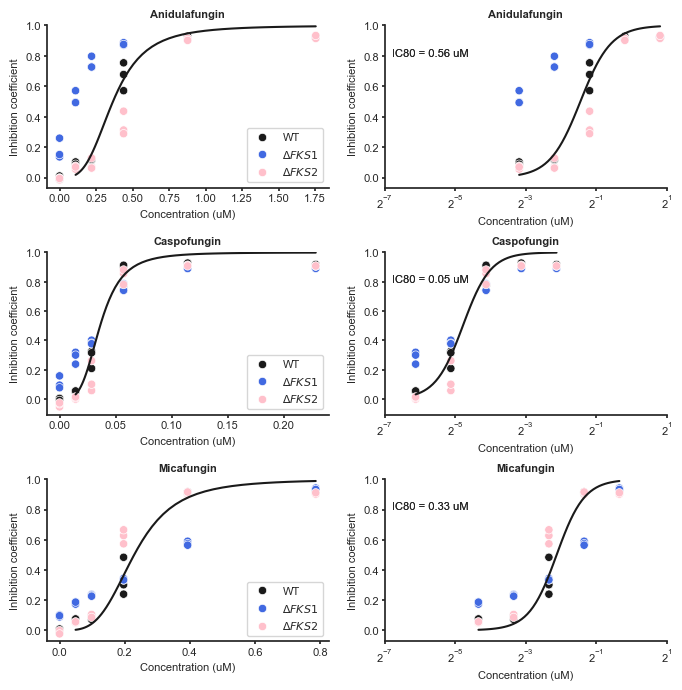

In [20]:
sns.set(rc = {'figure.figsize':(8,8),
              'font.family':'Arial',
              'font.size':8,
              'legend.title_fontsize':8, 'legend.fontsize':8,
              'axes.labelsize':8,'axes.titlesize':8,
              'xtick.labelsize':8, 'ytick.labelsize':8,
              'xtick.major.pad':2, 'ytick.major.pad':2,
              'xtick.bottom': True, 'ytick.left': True,
              'xtick.major.size':2, 'ytick.major.size':2,
              "axes.spines.right": False, "axes.spines.top": False
             },
       style='ticks')

fig, ax =plt.subplots(3,2, gridspec_kw = {'hspace':.4, 'wspace':.2})

comp_order = {0: ('anidulafungin', 'Anidulafungin'),
              1: ('caspofungin','Caspofungin'),
              2: ('micafungin','Micafungin')
             }
genot_dict = {'WT':'WT',
              'delta-FKS1-HS1':u'Δ$\it{FKS1}$',
              'delta-FKS2-HS1':u'Δ$\it{FKS2}$'
             }

for i in [0,1,2]:
    for j in [0,1]:
        ax[i][j].set_title(comp_order[i][1], weight='bold')
        fitdf = fit_data[fit_data.compound == comp_order[i][0]]
        ic80 = get_fit(fitdf)[1]
        
        g1 = sns.scatterplot(data=dgr[dgr.compound == comp_order[i][0]], x='concentration_uM', y='IC',
                             hue='genotype', hue_order=genot_dict.keys(), palette=['k','royalblue','pink'],
                             ax=ax[i][j])
        ax[i][j].plot(*get_fit(fitdf)[0], 'k-')
        
        if j==0:
            g1.set(ylim=(None,1))
            sns.move_legend(g1, "lower right", title=None)
            for ii, v in enumerate(genot_dict.values()):
                g1.legend_.texts[ii].set_text(v)
        else:
            g1.set(xlim=(2**-7,2), ylim=(None,1))
            g1.legend_.remove()
        ax[i][1].set_xscale('log', base=2)
        g1.set_xlabel('Concentration (uM)')
        g1.set_ylabel('Inhibition coefficient')
        ax[i][1].text(2**-6.8, 0.8, f'IC80 = {ic80} uM',
                      ha='left'
                     )

plt.savefig(f'{graph_outpath}/dose-response_IC.svg', format='svg', dpi=300)